In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from __future__ import print_function

import re
import numpy as np
import pandas as pd
import csv, json
from zipfile import ZipFile
from os.path import expanduser, exists

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

Using TensorFlow backend.


In [0]:
PATH = 'gdrive/My Drive/quora-question-pairs/'
TRAIN_CSV = 'train.csv'
# TEST_CSV = 'test.csv'à

data = pd.read_csv(PATH + TRAIN_CSV)
print(data.shape)
data.head()


(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
### Cleaning up contractions and numbers.
### from https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

### replacing 2 or more digits numbers with # 
### (most embeddings have preprocessed their text like this.)
def replace_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x


In [0]:

def text_cleanup(text):

    text = str(text)
    text = text.lower()
    text = replace_contractions(text)

    # Cleaning the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text) 
    text = re.sub(r"\0s", "0", text)

    text = replace_numbers(text)

    return text

In [0]:
PATH = 'gdrive/My Drive/quora-question-pairs/'
TRAIN_CSV = 'train.csv'

GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'

GLOVE_FILE = 'glove.840B.300d.txt'
Q1_TRAIN = 'q1_train.npy'
Q2_TRAIN = 'q2_train.npy'
LABEL_TRAIN = 'label_train.npy'
WORD_EMBEDDING_MATRIX = 'word_embedding_matrix.npy'
WORD_INDEX = 'word_index.json'

MAX_SEQ_LENGTH = 50
EMBEDDING_DIM = 300

In [0]:
### get and extract Glove embeddings
if not exists(PATH + GLOVE_ZIP_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE, path=PATH)  

In [0]:
### Loading QQP dataset
q1 = []
q2 = []
is_duplicate = []

with open(PATH + TRAIN_CSV, encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        q1.append(text_cleanup(row['question1']))
        q2.append(text_cleanup(row['question2']))
        is_duplicate.append(row['is_duplicate'])

print('Number of question pairs: %d' % len(q1))

Number of question pairs: 404290


In [0]:
### Tokenize questions into words
questions = q1 + q2
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)
q1_word_sequences = tokenizer.texts_to_sequences(q1)
q2_word_sequences = tokenizer.texts_to_sequences(q2)
word_index = tokenizer.word_index

print("Number of words in index: ", len(word_index))

Number of words in index:  80977


No handles with labels found to put in legend.


mean: 12.294492814563803; std 6.096567948140463; max 248


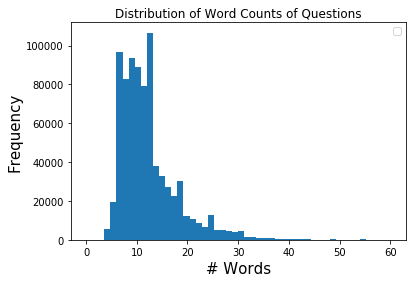

In [0]:
# Checking word count after preprocessing text
import matplotlib.pyplot as plt
import pandas as pd
questions = pd.Series(q1 + q2)
word_spread = questions.apply(lambda x: len(x.split(' ')))

plt.figure()
plt.hist(word_spread, bins=50, range=[0, 60])
plt.title('Distribution of Word Counts of Questions')
plt.legend()
plt.xlabel('# Words', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

print('mean: {}; std {}; max {}'.format(word_spread.mean(), word_spread.std(), word_spread.max()))

In [0]:
#### Loading Glove embeddings
embeddings_index = {}
with open(PATH + GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Number of word embeddings: ', len(embeddings_index))

Number of word embeddings:  2196017


In [0]:
### Creating the word embedding matrix
unknown_words = []
word_embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
    else:
        unknown_words.append(word) 

missing_embeddings = np.sum(np.sum(word_embedding_matrix, axis=1) == 0)
print('number of word without embeddings: ', missing_embeddings, )
print(missing_embeddings / len(word_index) * 100, '%' )

number of word without embeddings:  16991
20.982501204045594 %


In [0]:
print(unknown_words)

['kvpy', 'redmi', 'paytm', 'demonetisation', 'brexit', 'demonetize', 'quorans', 'demonetizing', 'cpec', 'iisc', 'oneplus', 'lyft', 'amcat', 'dangal', 'urjit', 'vishwanathan', 'zenfone', 'udemy', 'nsit', 'moocs', 'raghuram', 'elitmus', 'iitians', 'laravel', 'iocl', 'nmims', 'demonitization', 'duterte', 'jallikattu', 'zomato', 'upwork', 'srcc', 'duolingo', 'tqwl', 'pichai', 'demonetise', 'xlri', 'iitian', 'afcat', 'myntra', 'intjs', 'udacity', 'topcoder', 'ckwl', 'tensorflow', 'sanriku', 'shobhit', 'karakum', 'ranikhet', 'chihuahuan', 'hotstar', 'registan', 'taklamakan', 'uberx', 'venmo', 'demonetising', 'nicmar', 'unclos', 'qoura', 'rsus', 'iitb', 'broglie', 'demonitizing', 'rlwl', 'codecademy', 'jbims', 'upes', 'bhogle', 'chsl', 'kabali', 'dushka', 'sibm', 'iiser', 'nitie', 'hackerrank', 'chandrakar', 'lnmiit', 'chromecast', 'xamarin', 'jayalalithaa', 'coep', 'boruto', 'ximb', 'massachisetts', 'freecharge', 'ayurvedically', 'jeenkart', 'kylo', 'jinping', 'byju', 'josaa', 'socialtrade',

Most words without embeddings are either miss-spelled, proper nouns (company names, websites, etc.), or technical terms.  There also seems to be a lot of foreign words.


In [0]:
### padding training data
q1_data = pad_sequences(q1_word_sequences, maxlen=MAX_SEQ_LENGTH)
q2_data = pad_sequences(q2_word_sequences, maxlen=MAX_SEQ_LENGTH)
labels = np.array(is_duplicate, dtype=int)
print('Shape of q1 data:', q1_data.shape)
print('Shape of q2 data:', q2_data.shape)
print('Shape of label data:', labels.shape)

Shape of q1 data: (404290, 50)
Shape of q2 data: (404290, 50)
Shape of label data: (404290,)


In [0]:
# Saving relevant files for training models
np.save(open(PATH + Q1_TRAIN, 'wb'), q1_data)
np.save(open(PATH + Q2_TRAIN, 'wb'), q2_data)
np.save(open(PATH + LABEL_TRAIN, 'wb'), labels)
np.save(open(PATH + WORD_EMBEDDING_MATRIX, 'wb'), word_embedding_matrix)
with open(PATH + WORD_INDEX, 'w') as f:
    json.dump({'nb_words': len(word_index)}, f)